# Load packages

In [1]:
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load MERFISH and scRNAseq data

In [2]:
refdata = sc.read("../data/scRNAseq/scanpy_obj/in_vivo_w13_subset.h5ad")
adata = sc.read("../data/MERFISH/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15.h5ad")

# Harmony integration

In [3]:
# Combine the datasets
merged = adata.concatenate(
    refdata, batch_key="assay", batch_categories=["MERFISH", "scRNA-seq"]
)

In [4]:
sc.pp.scale(merged)
sc.tl.pca(merged)

In [5]:
# This step can take a few hours
sc.external.pp.harmony_integrate(merged, key="assay", max_iter_harmony=20, max_iter_kmeans=30)

2022-05-31 19:19:23,214 - harmonypy - INFO - Iteration 1 of 20
2022-05-31 19:22:57,217 - harmonypy - INFO - Iteration 2 of 20
2022-05-31 19:25:52,640 - harmonypy - INFO - Iteration 3 of 20
2022-05-31 19:28:08,761 - harmonypy - INFO - Iteration 4 of 20
2022-05-31 19:31:45,817 - harmonypy - INFO - Iteration 5 of 20
2022-05-31 19:33:15,318 - harmonypy - INFO - Iteration 6 of 20
2022-05-31 19:34:04,641 - harmonypy - INFO - Iteration 7 of 20
2022-05-31 19:34:53,710 - harmonypy - INFO - Converged after 7 iterations


In [6]:
# This part isn't necessary to do the label transfer, it's just to get the UMAP embedding for visualization
sc.pp.neighbors(merged, n_neighbors=30, use_rep="X_pca_harmony", metric="correlation")
sc.tl.umap(merged, min_dist=0.3)

... storing 'sample_id' as categorical
... storing 'batch' as categorical
... storing 'leiden' as categorical
... storing 'celltype' as categorical
... storing 'filter' as categorical
... storing 'orig.ident' as categorical
... storing 'Rep' as categorical
... storing 'Region' as categorical
... storing 'RNA_snn_res.0.8' as categorical
... storing 'seurat_clusters' as categorical
... storing 'clusters' as categorical
... storing 'colors' as categorical
... storing 'broad_celltype' as categorical


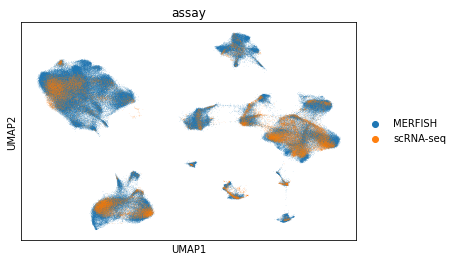

In [7]:
sc.pl.umap(merged, color='assay')

In [8]:
merged.write("../data/harmony/scanpy_obj/merfish_scRNAseq_harmony.h5ad")

# Transfer cell type annotations

## Overall cell type annotations

For each MERFISH cell, assign it the cell type of the nearest scRNAseq in the Harmony-corrected PCA space.

In [9]:
# Transfer annotations from scRNAseq to MERFISH
nn = KNeighborsClassifier(n_neighbors=1, n_jobs=16, weights='distance', metric='euclidean')
train = merged[merged.obs["assay"] == "scRNA-seq"]
nn.fit(train.obsm["X_pca_harmony"], train.obs['celltype']) 
labels = nn.predict(merged[merged.obs["assay"] == "MERFISH"].obsm["X_pca_harmony"])
merged.obs["scrnaseq_to_merfish_label"] = pd.Series(labels, index=merged[merged.obs["assay"] == "MERFISH"].obs.index)

# Save transferred annotations to file
scrnaseq_to_merfish_predicted_labels = merged.obs.loc[merged.obs['assay'] == 'MERFISH', ['sample_id','scrnaseq_to_merfish_label']]
scrnaseq_to_merfish_predicted_labels.index = scrnaseq_to_merfish_predicted_labels.index.str.replace('-MERFISH','')
scrnaseq_to_merfish_predicted_labels.to_csv('../data/harmony/label_transfer/scrnaseq_to_merfish_predicted_celltype.csv')

For each scRNAseq cell, assign it the cell type of the nearest MERFISH in the Harmony-corrected PCA space.

In [10]:
# Transfer annotations from MERFISH to scRNAseq
nn = KNeighborsClassifier(n_neighbors=1, n_jobs=16, weights='distance', metric='euclidean')
train = merged[merged.obs["assay"] == "MERFISH"]
nn.fit(train.obsm["X_pca_harmony"], train.obs['celltype']) 
labels = nn.predict(merged[merged.obs["assay"] == "scRNA-seq"].obsm["X_pca_harmony"])
merged.obs["merfish_to_scrnaseq_label"] = pd.Series(labels, index=merged[merged.obs["assay"] == "scRNA-seq"].obs.index)

# Save transferred annotations to file
merfish_to_scrnaseq_predicted_labels = merged.obs.loc[merged.obs['assay'] == 'scRNA-seq', ['orig.ident','merfish_to_scrnaseq_label']]
merfish_to_scrnaseq_predicted_labels.index = merfish_to_scrnaseq_predicted_labels.index.str.replace('-scRNA-seq','')
merfish_to_scrnaseq_predicted_labels.to_csv('../data/harmony/label_transfer/merfish_to_scrnaseq_predicted_celltype.csv')

... storing 'scrnaseq_to_merfish_label' as categorical
... storing 'merfish_to_scrnaseq_label' as categorical
... storing 'final_label' as categorical


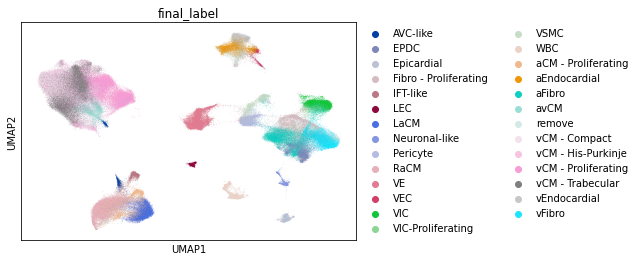

In [12]:
# Combine original labels from scRNA-seq and transferred labels from MERFISH into one column
merged.obs.loc[merged.obs['assay'] == 'MERFISH', 'final_label'] = merged.obs[merged.obs['assay'] == 'MERFISH']['scrnaseq_to_merfish_label']
merged.obs.loc[merged.obs['assay'] == 'scRNA-seq', 'final_label'] = merged.obs[merged.obs['assay'] == 'scRNA-seq']['celltype']

# Visualized merged labels on UMAP
sc.pl.umap(merged, color='final_label')

Comparing MERFISH annotations vs transferred scRNAseq annotations in co-occurrence matrix.

Trying to set attribute `.obs` of view, copying.


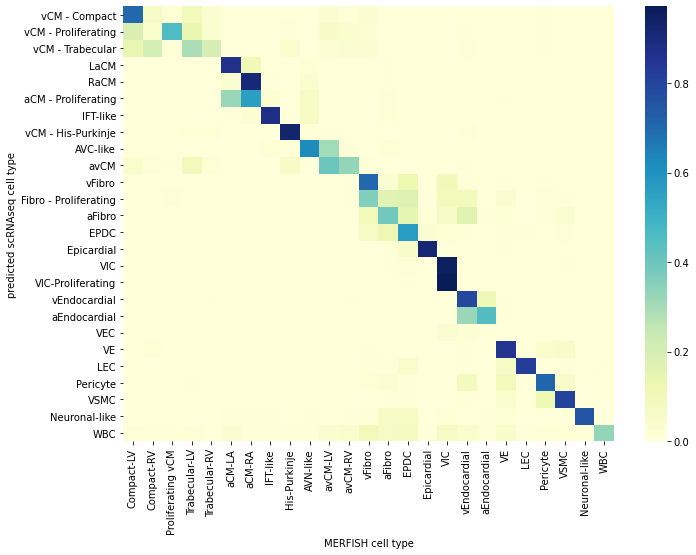

In [14]:
# Visualize MERFISH annotations vs transferred scRNAseq annotations
merfish_obj = merged[merged.obs['assay']=='MERFISH']
merfish_obj.obs['celltype'] = merfish_obj.obs['celltype'].astype('str')
celltype_counts = pd.DataFrame(merfish_obj.obs.groupby(['celltype','scrnaseq_to_merfish_label']).size()).unstack()
celltype_counts.columns = celltype_counts.columns.droplevel()
celltype_counts.index.name = 'MERFISH cell type'
celltype_counts.columns.name = 'predicted scRNAseq cell type'
celltype_counts = celltype_counts.T
# Row scale co-occurrence frequencies (by predicted scRNAseq cell type)
celltype_counts = celltype_counts.div(celltype_counts.sum(axis=1), axis=0) 
celltype_counts = celltype_counts.loc[:,celltype_counts.idxmax(axis=0).sort_values().index]
celltype_counts = celltype_counts.fillna(0)

# Order rows and columns
predicted_sc_order = ['vCM - Compact','vCM - Proliferating','vCM - Trabecular','LaCM','RaCM',
                      'aCM - Proliferating','IFT-like','vCM - His-Purkinje','AVC-like','avCM',
                      'vFibro','Fibro - Proliferating','aFibro','EPDC','Epicardial','VIC',
                      'VIC-Proliferating','vEndocardial','aEndocardial','VEC','VE','LEC',
                      'Pericyte','VSMC','Neuronal-like','WBC']
merfish_order = ['Compact-LV','Compact-RV','Proliferating vCM','Trabecular-LV','Trabecular-RV',
                 'aCM-LA','aCM-RA','IFT-like','His-Purkinje','AVN-like','avCM-LV','avCM-RV',
                 'vFibro','aFibro','EPDC','Epicardial','VIC','vEndocardial','aEndocardial',
                 'VE','LEC','Pericyte','VSMC','Neuronal-like','WBC']
celltype_counts = celltype_counts.loc[predicted_sc_order,merfish_order]

plt.figure(figsize = (11,8))
sns.heatmap(celltype_counts, cmap='YlGnBu')
plt.savefig('../figures/Fig1/scRNAseq_to_MERFISH_classification_freq_heatmap.pdf', bbox_inches='tight')

## Ventricle subset annotations

In [15]:
adata_merfish_subset = sc.read_h5ad('../data/MERFISH/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15_ventricle.h5ad')
adata_merfish_subset.obs.index = adata_merfish_subset.obs.index + '-MERFISH'

Label all non-ventricle cells as 'Atria'.

In [16]:
merged.obs['celltype_vent'] = 'Atria'
merged.obs.loc[adata_merfish_subset.obs.index, 'celltype_vent'] = adata_merfish_subset.obs['celltype_vent']

In [17]:
# Transfer annotations from MERFISH to scRNAseq
nn = KNeighborsClassifier(n_neighbors=1, n_jobs=16, weights='distance', metric='euclidean')
train = merged[merged.obs["assay"] == "MERFISH"]
nn.fit(train.obsm["X_pca_harmony"], train.obs['celltype_vent']) # celltype is the label to transfer from MERFISH
labels = nn.predict(merged[merged.obs["assay"] == "scRNA-seq"].obsm["X_pca_harmony"])
merged.obs["merfish_vent_to_scrnaseq_label"] = pd.Series(labels, index=merged[merged.obs["assay"] == "scRNA-seq"].obs.index)

# Save transferred annotations to file
merfish_to_scrnaseq_predicted_labels = merged.obs.loc[merged.obs['assay'] == 'scRNA-seq', ['orig.ident','merfish_vent_to_scrnaseq_label']]
merfish_to_scrnaseq_predicted_labels.index = merfish_to_scrnaseq_predicted_labels.index.str.replace('-scRNA-seq','')
merfish_to_scrnaseq_predicted_labels.to_csv('../data/harmony/label_transfer/merfish_vent_to_scrnaseq_predicted_celltype.csv')

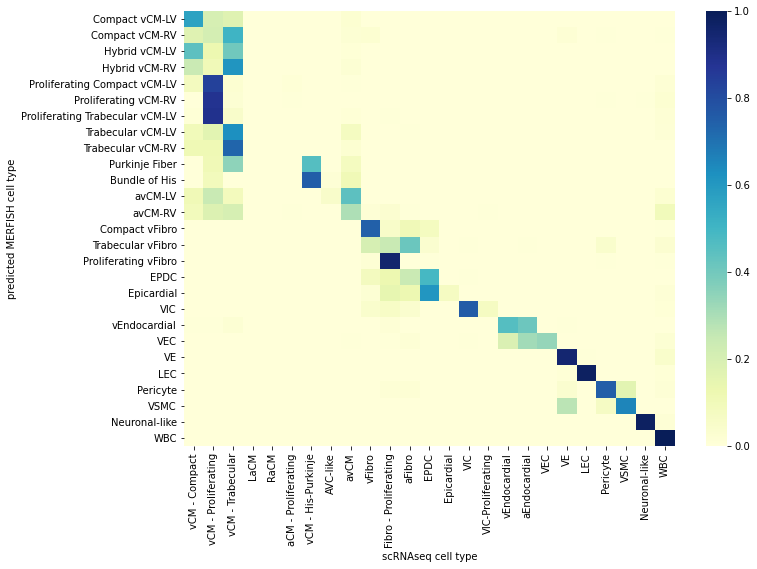

In [28]:
rna_obj = merged[merged.obs['assay']=='scRNA-seq']
# Remove all cells assigned to non-ventricle cell type
rna_obj = rna_obj[rna_obj.obs['merfish_vent_to_scrnaseq_label']!='Atria'] 
celltype_counts = pd.DataFrame(rna_obj.obs.groupby(['celltype','merfish_vent_to_scrnaseq_label']).size()).unstack()
celltype_counts.columns = celltype_counts.columns.droplevel()
celltype_counts.index.name = 'scRNAseq cell type'
celltype_counts.columns.name = 'predicted MERFISH cell type'
celltype_counts = celltype_counts.T
# row scale co-occurrence frequencies (by predicted MERFISH cell type)
celltype_counts = celltype_counts.div(celltype_counts.sum(axis=1), axis=0)
celltype_counts = celltype_counts.loc[:,celltype_counts.idxmax(axis=0).sort_values().index]
celltype_counts = celltype_counts.fillna(0)

# Order rows and columns
sc_order = ['vCM - Compact','vCM - Proliferating','vCM - Trabecular','LaCM','RaCM',
              'aCM - Proliferating','vCM - His-Purkinje','AVC-like','avCM',
              'vFibro','Fibro - Proliferating','aFibro','EPDC','Epicardial','VIC',
              'VIC-Proliferating','vEndocardial','aEndocardial','VEC','VE','LEC',
              'Pericyte','VSMC','Neuronal-like','WBC']
predicted_merfish_order = ['Compact vCM-LV', 'Compact vCM-RV', 'Hybrid vCM-LV', 'Hybrid vCM-RV', 
                         'Proliferating Compact vCM-LV', 'Proliferating vCM-RV', 
                         'Proliferating Trabecular vCM-LV', 'Trabecular vCM-LV', 'Trabecular vCM-RV', 'Purkinje Fiber', 
                         'Bundle of His', 'avCM-LV', 'avCM-RV', 'Compact vFibro', 'Trabecular vFibro', 
                         'Proliferating vFibro', 'EPDC', 'Epicardial', 
                         'VIC', 'vEndocardial', 'VEC', 'VE', 'LEC', 'Pericyte', 'VSMC', 'Neuronal-like', 'WBC']
celltype_counts = celltype_counts.loc[predicted_merfish_order,sc_order]
# celltype_counts = celltype_counts.loc[:,sc_order]

plt.figure(figsize = (11,8))
sns.heatmap(celltype_counts, cmap='YlGnBu')
plt.savefig('../figures/Ext_Dat_Fig8/scRNAseq_to_MERFISH_ventricle_classification_freq_heatmap.pdf', bbox_inches='tight')

# Transfer scRNAseq expression to MERFISH

In [29]:
scrna = sc.read("../data/scRNAseq/scanpy_obj/in_vivo_w13_subset.h5ad")

In [30]:
sc.pp.highly_variable_genes(scrna, flavor='seurat_v3', n_top_genes=2000)

/home/ubuntu/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [31]:
genes = scrna.var.index[scrna.var.highly_variable].union(adata.var.index).union(['SEMA3C','SEMA3D','SEMA6A','SEMA6B'])

In [32]:
# Read in scRNAseq expression values
# scrnaseq_exp = sc.read('../data/scRNAseq/scanpy_obj/in_vivo_w13_15_subcluster_celltypes.h5ad').to_df()
scrnaseq_exp = scrna[:,genes].to_df()
scrnaseq_exp = scrnaseq_exp.loc[:, (scrnaseq_exp != 0).any(axis=0)] # Drop genes without any counts

For each MERFISH cell, assign it the expression profile (top 2000 variable genes) of the nearest scRNAseq in the Harmony-corrected PCA space.

In [33]:
# Transfer scRNAseq expression to MERFISH 
nn = NearestNeighbors(n_jobs=16)
nn.fit(merged[merged.obs["assay"] == "scRNA-seq"].obsm["X_pca_harmony"])
dist, inds = nn.kneighbors(merged[merged.obs["assay"] == "MERFISH"].obsm["X_pca_harmony"], n_neighbors=1)
predicted_merfish_exp = pd.DataFrame(scrnaseq_exp.iloc[inds.flatten()].to_numpy(), 
                                     index=merged[merged.obs["assay"] == "MERFISH"].obs.index, 
                                     columns=scrnaseq_exp.columns)

In [34]:
# Save transferred scRNAseq expression to file
predicted_merfish_exp.to_csv('../data/harmony/vFISH/vfish_results.csv')

In [35]:
# Read vFISH results into Scanpy object
adata_vfish = sc.read_csv('../data/harmony/vFISH/vfish_results.csv')

In [36]:
# Add spatial coordinates and metadata from original MERFISH object
adata_vfish.obsm['spatial'] = sc.read("../data/MERFISH/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15.h5ad").obsm['spatial']
adata_vfish.obs = sc.read("../data/MERFISH/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15.h5ad").obs

In [37]:
# Save vFISH object
adata_vfish.write('../data/harmony/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15_vFISH.h5ad')

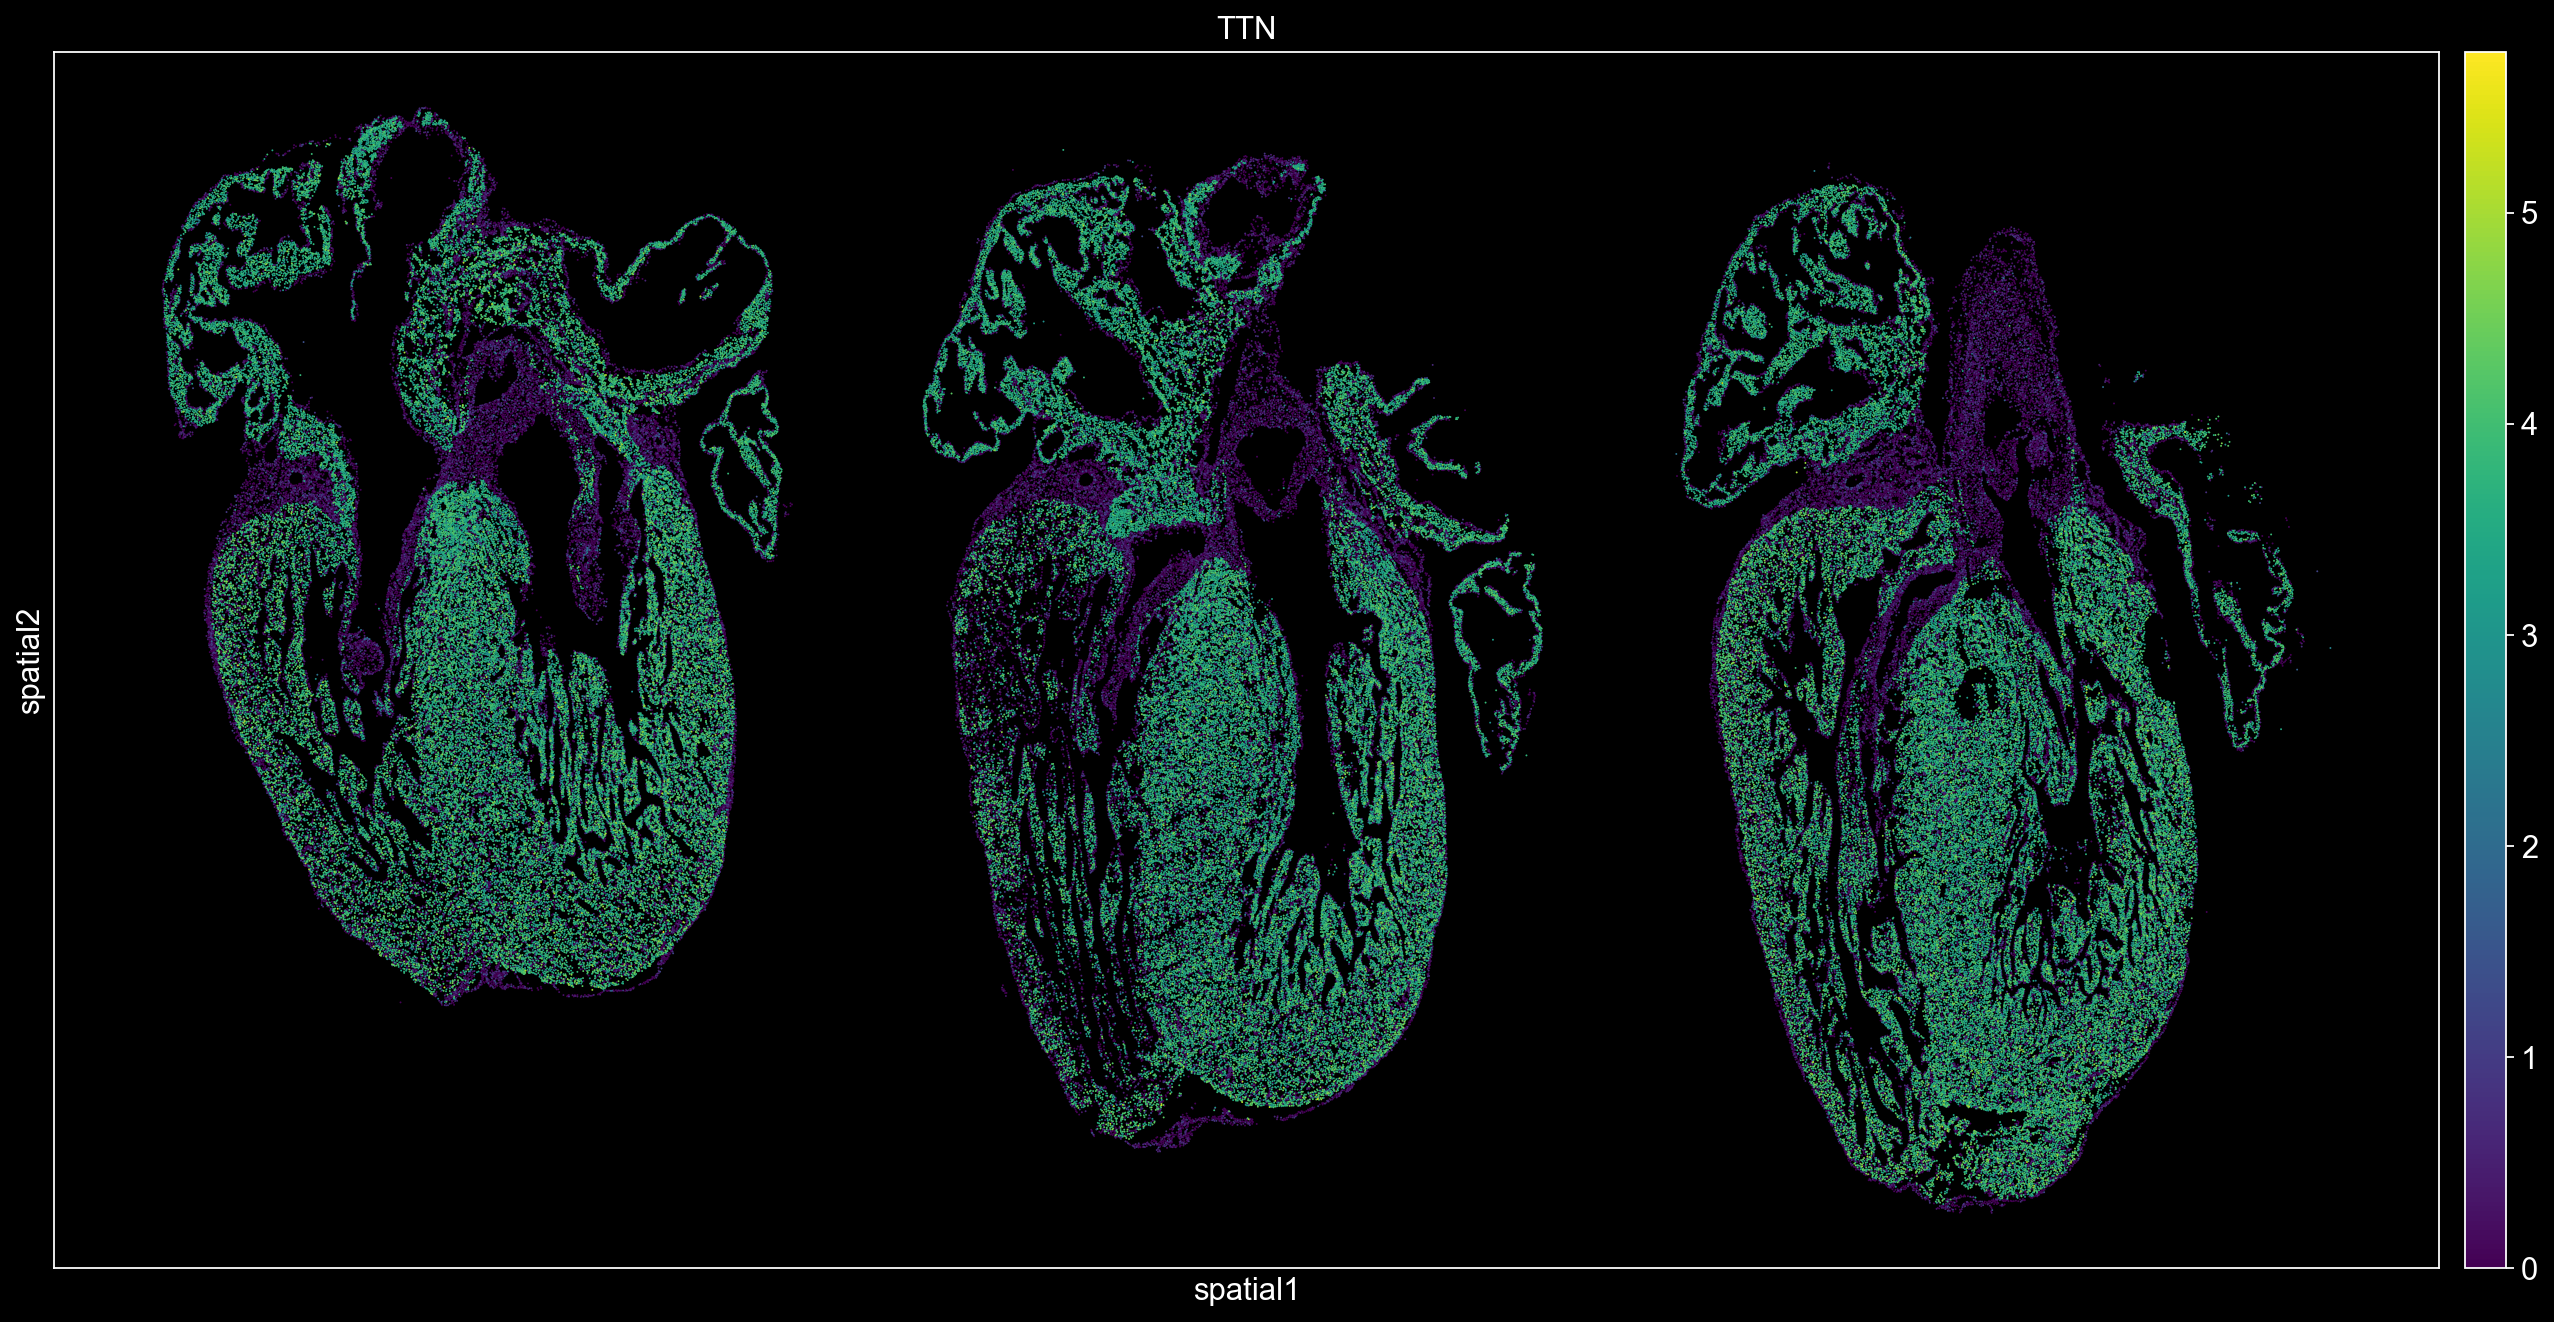

In [38]:
sc.set_figure_params(figsize=[21,10])
plt.style.use('dark_background')
sc.pl.embedding(adata_vfish, 
                basis="spatial", color="TTN", size=3)
plt.style.use('default')